In [1]:
import xarray as xr
import intake
import xesmf as xe
import PyCO2SYS as pyco2
import matplotlib.pyplot as plt
import numpy as np
import gsw
from dask.diagnostics import ProgressBar
from cmip6_preprocessing.preprocessing import combined_preprocessing
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables

In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

In [3]:
variables = ['dissic','talk', 'so', 'thetao', 'fgco2']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gn'],
             source_id=['IPSL-CM6A-LR'],
            member_id=['r11i1p1f1'])

cat = col.search(**query)

dd = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

dd = merge_variables(dd)
list(dd.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['IPSL-CM6A-LR.gn.historical.Omon.r11i1p1f1']

In [4]:
#############
### Not needed at the moment because I'm taking only one model and one member
#############
# # temp={}
# # for name,item in dd_gn.items():
# #     #print(name)
# #     #print(item.data_vars)
# #     present = item.data_vars
# #     if all(i in present for i in variables):
# #         #print(name)
# #         temp[name]=item
# # dd_gn = temp

# def pick_first_member(ds_list, **kwargs):
#     return ds_list[0]

# dd = combine_datasets(
#     dd,
#     pick_first_member,
#     match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
# )

In [5]:
# Regrid
targetgrid_ds = xe.util.grid_global(1.0, 1.0)
targetgrid_ds['lon'] = targetgrid_ds['lon']+180
targetgrid_ds['lon_b'] = targetgrid_ds['lon_b']+180
newcoords = {'x':targetgrid_ds['lon'][0,:],'y':targetgrid_ds['lat'][:,0]}

dd_regrid={}
for name,item in dd.items():
    regridder = xe.Regridder(item, targetgrid_ds, 'bilinear', 
                         periodic=True, ignore_degenerate=True)
    ds_regridded = regridder(item).assign_coords(**newcoords).chunk({'time':1})
    dd_regrid[name]=ds_regridded
list(dd_regrid.keys())

/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


['IPSL-CM6A-LR.gn.historical.Omon.r11i1p1f1']

In [10]:
# select = {'time':slice('1850-01-01','1850-12-31'),'x':slice(180,200)}
# iselect = {'time':0}
ds = dd_regrid['IPSL-CM6A-LR.gn.historical.Omon.r11i1p1f1']#.isel(iselect)
ds['p'] = gsw.p_from_z(-1*ds['lev'], ds['lat'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
ds['p'] = ds['p']*xr.ones_like(ds['talk']) # expand along time dimension
ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], ds['p'])
ds = ds.transpose(*tuple(ds.dims))
conversion =  1e6/1035
def pyco2sys_wrapper(ds):
    args = {'par1':(ds['talk']*conversion),
            'par2':(ds['dissic']*conversion),
            'par1_type':1,
            'par2_type':2,
            'pressure_out':0,
            'temperature_out':ds['thetao'], 
            'pressure':ds['p'],
            'temperature':ds['insitutemp']}
    results = pyco2.sys(**args)
    return ds['talk'].copy(data=results['pCO2_out'])

ds['PpCO2'] = xr.map_blocks(pyco2sys_wrapper,ds,template=ds['talk'])

In [13]:
ds['PpCO2']

<xarray.DataArray 'PpCO2' (lev: 75, time: 1980, x: 360, y: 180)>
dask.array<pyco2sys_wrapper-99898114bd96af08db08ea4c5764fb7e-<this, shape=(75, 1980, 360, 180), dtype=float64, chunksize=(75, 1, 360, 180), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 0.5058 1.556 2.668 ... 5.495e+03 5.698e+03 5.902e+03
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    lon      (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lat      (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

[########################################] | 100% Completed |  1min 19.1s


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


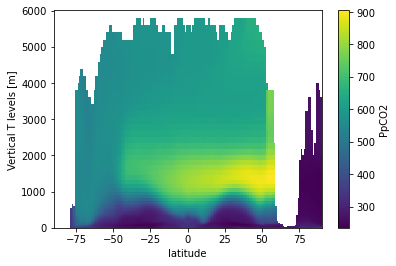

In [7]:
with ProgressBar():
    ds['PpCO2'].mean(['time','x']).plot()

In [49]:
times = ds['time'].isel({'time':slice(0,12)})
varmean = np.zeros(shape=)
for time in times:
    

('bnds', 'lev', 'time', 'x', 'y')